In [4]:
# https://www.kaggle.com/serkanpeldek/keras-cnn-transfer-learnings-on-cats-dogs-dataset/notebook
# https://data-flair.training/blogs/cats-dogs-classification-deep-learning-project-beginners/

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import applications

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import SGD

import os


In [5]:
# Randomly Visualization of Samples in the Dataset
import zipfile

zip_files = ['test1', 'train']
# Will unzip the files so that you can see them..
for zip_file in zip_files:
    with zipfile.ZipFile("{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))


test1 unzipped
train unzipped


In [6]:
IMAGE_FOLDER_PATH="train"
FILE_NAMES=os.listdir(IMAGE_FOLDER_PATH)
WIDTH=150
HEIGHT=150

targets=list()
full_paths=list()
for file_name in FILE_NAMES:
    target=file_name.split(".")[0]
    full_path=os.path.join(IMAGE_FOLDER_PATH, file_name)
    full_paths.append(full_path)
    targets.append(target)

dataset=pd.DataFrame()
dataset['image_path']=full_paths
dataset['target']=targets

print(dataset.head())

target_counts=dataset['target'].value_counts()
print("Number of dogs in the dataset:{}".format(target_counts['dog']))
print("Number of cats in the dataset:{}".format(target_counts['cat']))

            image_path target
0  train/dog.10694.jpg    dog
1  train/cat.11915.jpg    cat
2   train/dog.4214.jpg    dog
3   train/dog.1140.jpg    dog
4   train/dog.7814.jpg    dog
Number of dogs in the dataset:12500
Number of cats in the dataset:12500


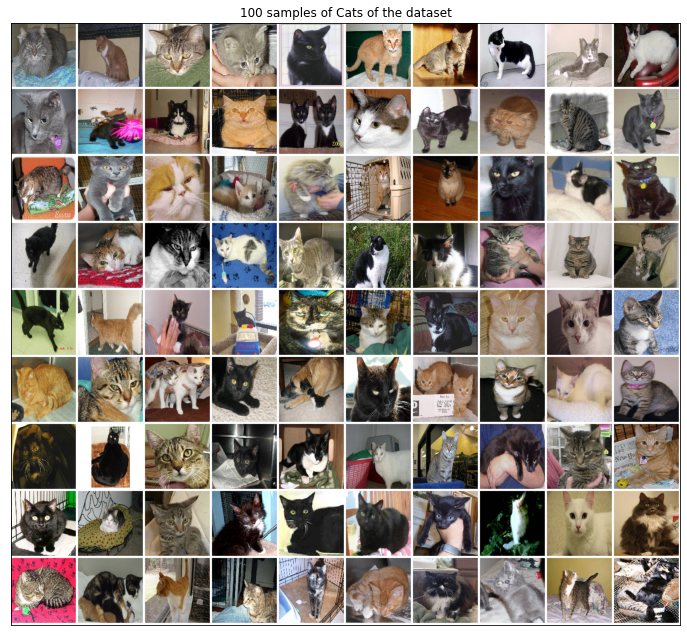

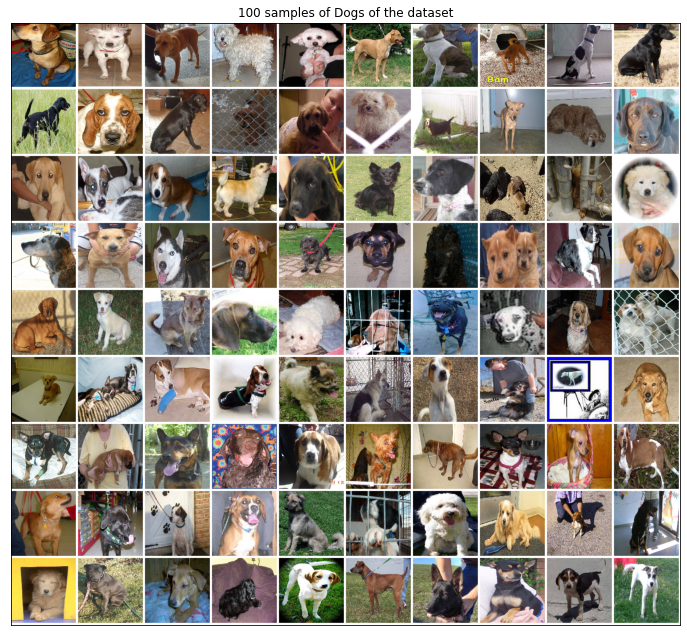

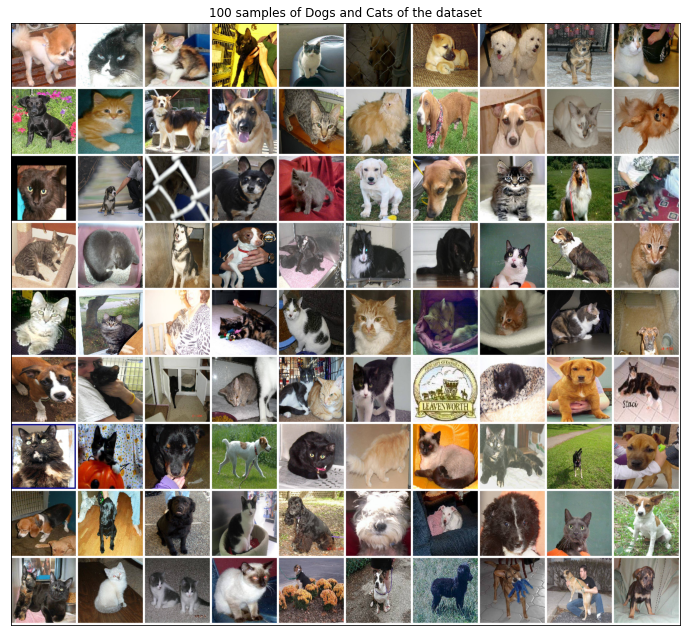

In [7]:
def get_side(img, side_type, side_size=5):
    height, width, channel = img.shape
    if side_type == "horizontal":
        return np.ones((height, side_size, channel), dtype=np.float32) * 255

    return np.ones((side_size, width, channel), dtype=np.float32) * 255


def show_gallery(show="both"):
    n = 100
    counter = 0
    images = list()
    vertical_images = []
    rng_state = np.random.get_state()
    np.random.shuffle(full_paths)
    np.random.set_state(rng_state)
    np.random.shuffle(targets)
    for path, target in zip(full_paths, targets):
        if target != show and show != "both":
            continue
        counter = counter + 1
        if counter % 100 == 0:
            break
        # Image loading from disk as JpegImageFile file format
        img = load_img(path, target_size=(WIDTH, HEIGHT))
        # Converting JpegImageFile to numpy array
        img = img_to_array(img)

        hside = get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter % 10 == 0:
            himage = np.hstack((images))
            vside = get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)

            images = list()

    gallery = np.vstack((vertical_images))
    plt.figure(figsize=(12, 12))
    plt.xticks([])
    plt.yticks([])
    title = {"both": "Dogs and Cats",
             "cat": "Cats",
             "dog": "Dogs"}
    plt.title("100 samples of {} of the dataset".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))

show_gallery(show="cat")
show_gallery(show="dog")
show_gallery(show="both")

In [8]:
# Convolutional Neural Network(CNN)
def show_model_history(modelHistory, model_name):
    history = pd.DataFrame()
    history["Train Loss"] = modelHistory.history['loss']
    history["Validatin Loss"] = modelHistory.history['val_loss']
    history["Train Accuracy"] = modelHistory.history['accuracy']
    history["Validatin Accuracy"] = modelHistory.history['val_accuracy']

    history.plot(figsize=(12, 8))
    plt.title(" Convulutional Model {} Train and Validation Loss and Accuracy History".format(model_name))
    plt.show()

In [9]:
#  Implementing CNN Architecture with Keras
model = Sequential()
# CONV 1A
model.add(Conv2D(32, (3,3), padding='same', activation="relu", kernel_initializer='he_uniform', use_bias=False, input_shape=(WIDTH, HEIGHT, 3)))
# Normalize the data
model.add(BatchNormalization())
# CONV 1B
model.add(Conv2D(32, (3,3), padding='same', activation="relu", kernel_initializer='he_uniform', use_bias=False))
# Normalize the data
model.add(BatchNormalization())
# POOL 1
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

# CONV 2A
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', use_bias=False))
# Normalize the data
model.add(BatchNormalization())
# CONV 2B
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', use_bias=False))
# Normalize the data
model.add(BatchNormalization())
# POOL 2
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# CONV 3A
model.add(Conv2D(96, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', use_bias=False))
# Normalize the data
model.add(BatchNormalization())
# CONV 3B
model.add(Conv2D(96, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', use_bias=False))
# Normalize the data
model.add(BatchNormalization())
# POOL 3
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# CONV 4A
model.add(Conv2D(128, (3,3),padding='same', activation='relu', kernel_initializer='he_uniform', use_bias=False))
# Normalize the data
model.add(BatchNormalization())
# CONV 4B
model.add(Conv2D(128, (3,3),padding='same', activation='relu', kernel_initializer='he_uniform', use_bias=False))
# Normalize the data
model.add(BatchNormalization())
# POOL 4
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# CONV 5A
model.add(Conv2D(256, (3,3),padding='same', activation='relu', kernel_initializer='he_uniform', use_bias=False))
# Normalize the data
model.add(BatchNormalization())
# CONV 5B
model.add(Conv2D(256, (3,3),padding='same', activation='relu', kernel_initializer='he_uniform', use_bias=False))
# Normalize the data
model.add(BatchNormalization())
# POOL 5
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# CONV 6A
model.add(Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', use_bias=False))
# Normalize the data
model.add(BatchNormalization())
# CONV 6B
model.add(Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', use_bias=False))
# Normalize the data
model.add(BatchNormalization())
# POOL 6
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))

# Compile the model by using SGD
opt = SGD(learning_rate=0.001, momentum=0.9)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      864       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        1

In [10]:
# Training dataset preparation
# Setup number of epochs and batch size
EPOCHS = 100
BATCH = 128

dataset_train, dataset_test=train_test_split(dataset, test_size=0.2, random_state=42)

train_datagen=ImageDataGenerator(rotation_range=15, rescale=1.0/255, shear_range=0.1, 
                                 zoom_range=0.2, width_shift_range=0.1, 
                                 height_shift_range=0.1, horizontal_flip=True)


train_datagenerator=train_datagen.flow_from_dataframe(dataframe=dataset_train, x_col="image_path",
                                                     y_col="target", target_size=(150, 150),
                                                     class_mode="binary", batch_size=BATCH)

test_datagen=ImageDataGenerator(rescale=1./255)
test_datagenerator=test_datagen.flow_from_dataframe(dataframe=dataset_test, x_col="image_path",
                                                   y_col="target", target_size=(150, 150),
                                                   class_mode="binary", batch_size=BATCH)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [12]:
# Model training

import os
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

# Load a pre-trained model if exists
if os.path.exists('CATS_DOGS_MODEL.h5'):
  model = load_model('CATS_DOGS_MODEL.h5')

# Define callbacks
checkpoint = ModelCheckpoint(filepath='CATS_DOGS_MODEL.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit model with training dataset
history = model.fit_generator(train_datagenerator, steps_per_epoch=len(train_datagenerator), 
                              validation_data=test_datagenerator, epochs=EPOCHS, callbacks=[checkpoint])
# modelHistory=model.fit_generator(train_datagenerator, epochs=EPOCHS, validation_data=test_datagenerator, 
# validation_steps=dataset_test.shape[0]//150, steps_per_epoch=dataset_train.shape[0]//150)

_, acc = model.evaluate(test_datagenerator, steps=len(test_datagenerator), verbose=1)
print('> %.3f' % (acc * 100.0))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
157/157 [==============================] - 154s 961ms/step - loss: 0.5206 - accuracy: 0.7518 - val_loss: 0.4906 - val_accuracy: 0.7824

Epoch 00001: val_accuracy improved from -inf to 0.78240, saving model to CATS_DOGS_MODEL.h5
Epoch 2/100
157/157 [==============================] - 151s 960ms/step - loss: 0.4084 - accuracy: 0.8119 - val_loss: 0.3679 - val_accuracy: 0.8644

Epoch 00002: val_accuracy improved from 0.78240 to 0.86440, saving model to CATS_DOGS_MODEL.h5
Epoch 3/100
157/157 [==============================] - 151s 962ms/step - loss: 0.3126 - accuracy: 0.8675 - val_loss: 0.2871 - val_accuracy: 0.8874

Epoch 00003: val_accuracy improved from 0.86440 to 0.88740, saving model to CATS_DOGS_MODEL.h5
Epoch 4/100
157/157 [==============================] - 151s 958ms/step - loss: 0.2661 - accuracy: 0.8878 - val_loss: 0.2089 - val_accuracy: 0.9140

Epoch 00004: val_accuracy improved from 0.88740 to 0.91400, saving model to CATS_DOGS_MODEL.h5
Epoch 5/100
157/157 [==========

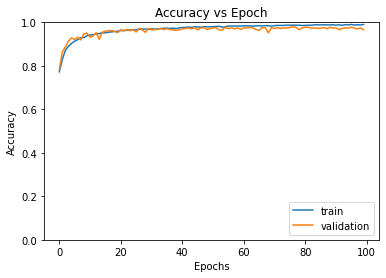

In [13]:
# Plot graph for accuracy and validation accuracy
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.ylim(0, 1)
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
except:
    print("Missing metric to plot graph.")

In [14]:
# Fit the model on full dataset
'''
checkpoint = ModelCheckpoint(filepath = 'CATS_DOGS_MODEL.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
model.fit(train_datagenerator, steps_per_epoch=len(train_datagenerator), validation_data=test_datagenerator, epochs=EPOCHS, batch_size=BATCH, callbacks=[checkpoint])
'''

"\ncheckpoint = ModelCheckpoint(filepath = 'CATS_DOGS_MODEL.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')\nmodel.fit(train_datagenerator, steps_per_epoch=len(train_datagenerator), validation_data=test_datagenerator, epochs=EPOCHS, batch_size=BATCH, callbacks=[checkpoint])\n"

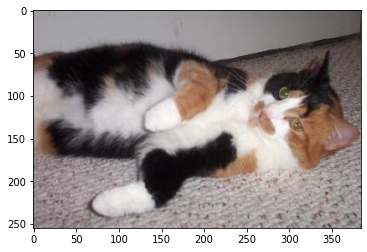

(1, 150, 150, 3)
Cat


In [15]:
# make a prediction for a new image.
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import matplotlib.image as mpimg
 
# load and prepare the image
def load_test_image(filename):
	# load the image
	img = load_img(filename, target_size=(150, 150))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 150, 150, 3)
	# center pixel data
	img = img.astype('float32')
	img = img/255
	return img

img_file = 'sample_image3.jpg'

# load the image
img1 = mpimg.imread(img_file)
imgplot = plt.imshow(img1)
plt.show()
img1 = load_test_image(img_file)
print(img1.shape)
# load model
model = load_model('CATS_DOGS_MODEL.h5')

# predict the class
test_preds = model.predict(img1)
if test_preds <0.5:
  print('Cat')
else:
  print('Dog')
 

In [16]:
#GUI
'''
### CREATE VIRTUAL DISPLAY ###
!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0'    # tell X clients to use our virtual DISPLAY :1.0.

import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy

from keras.models import load_model
model = load_model('CATS_DOGS_MODEL.h5')
#dictionary to label all traffic signs class.
classes = { 
    0:'its a cat',
    1:'its a dog',
 
}
#initialise GUI
top=tk.Tk()
top.geometry('800x600')
top.title('CatsVSDogs Classification')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)
def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    image = image.resize((128,128))
    image = numpy.expand_dims(image, axis=0)
    image = numpy.array(image)
    image = image/255
    pred = model.predict_classes([image])[0]
    sign = classes[pred]
    print(sign)
    label.configure(foreground='#011638', text=sign) 
def show_classify_button(file_path):
    classify_b=Button(top,text="Classify Image",
   command=lambda: classify(file_path),
   padx=10,pady=5)
    classify_b.configure(background='#364156', foreground='white',
font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)

def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),
    (top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass
upload=Button(top,text="Upload an image",command=upload_image,padx=10,pady=5)
upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="CatsVSDogs Classification",pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()
'''

'\n### CREATE VIRTUAL DISPLAY ###\n!apt-get install -y xvfb # Install X Virtual Frame Buffer\nimport os\nos.system(\'Xvfb :1 -screen 0 1600x1200x16  &\')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8\nos.environ[\'DISPLAY\']=\':1.0\'    # tell X clients to use our virtual DISPLAY :1.0.\n\nimport tkinter as tk\nfrom tkinter import filedialog\nfrom tkinter import *\nfrom PIL import ImageTk, Image\nimport numpy\n\nfrom keras.models import load_model\nmodel = load_model(\'CATS_DOGS_MODEL.h5\')\n#dictionary to label all traffic signs class.\nclasses = { \n    0:\'its a cat\',\n    1:\'its a dog\',\n \n}\n#initialise GUI\ntop=tk.Tk()\ntop.geometry(\'800x600\')\ntop.title(\'CatsVSDogs Classification\')\ntop.configure(background=\'#CDCDCD\')\nlabel=Label(top,background=\'#CDCDCD\', font=(\'arial\',15,\'bold\'))\nsign_image = Label(top)\ndef classify(file_path):\n    global label_packed\n    image = Image.open(file_path)\n    image = image.res